In [1]:
# Importing relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import os

In [2]:
# Setting the working directory

working_directory = "C:\Projects\AkzoNobel interview presentation\Data"
os.chdir(working_directory)

#### Data importing

In [3]:
# Importing the transformed data

data = pd.read_csv("Transformed data.csv")

In [4]:
data.head(1) # checking the import

,Unnamed: 0,Datetime,Speed Through Water [kts],Shaft Power [kW],Fuel Oil Cons. [kg/hour],Shaft Speed [RPM],Torque [nM],Wind Speed Abs. [kts],Speed Over Ground [kts],Draft Aft [m],...,month,year,hour,minute,second,location,distance covered (nmi),time elapsed (hrs),fuel efficiency,hull stability
0,1,2018-07-19 01:00:00,10.663333,6580.133333,1164.266667,42.005833,1495.941667,12.165,11.729167,20.455,...,7,2018,1,0,0,"(6.0, 96.675)",40.35192,1.0,34.658658,0.090833


#### Model specific transformations

In [5]:
# Grouping the data date wise for implementing ARIMAX model

data["dates"] = pd.to_datetime(data["Datetime"]).dt.date


# Identifying the exogeneous and endogeneous features required for forecasting

df = data.groupby("dates").agg({"Fuel Oil Cons. [kg/hour]" : "mean", "Torque [nM]" : "mean", "Speed Through Water [kts]" : "mean", "Shaft Power [kW]" : "mean", "Shaft Speed [RPM]" : "mean"}).reset_index()

# Making the time difference between rows uniform

date_range = pd.date_range(start=df["dates"].min(), end=df["dates"].max(), freq='D')
dates_df = pd.DataFrame({'dates': date_range})

df = df.reset_index()
df["dates"] = pd.to_datetime(df["dates"])

df = pd.merge(dates_df, df, on="dates", how="left")
df.fillna(0, inplace=True)

#### Stationarity check

Null hypothesis : The target variable is not stationary
Alternative hypothesis : The target variable is stationary

If p-value < 0.05, reject the null hypothesis.

In other words, for a time series variable to be stationary, p-value must be less than 0.05.

In [6]:
# Checking the variation of mean and variance of target variable over time using an ADFULLER test

from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Fuel Oil Cons. [kg/hour]"])
result

(-8.662462288676245,
 4.7815078239015e-14,
 5,
 2018,
 {'1%': -3.4335946172657774,
  '5%': -2.8629733042364576,
  '10%': -2.567533028727577},
 29383.41877354375)

Here, p-value is very close to zero and is definitely less than 0.05.

Therefore we can reject the null hypothesis, the time series variable is stationary.

#### ACF and PACF plots

It is necessary to plot the autocorrelation function and partial autocorrelation function plots to identify the p,d and q components in an ARIMAX model function.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

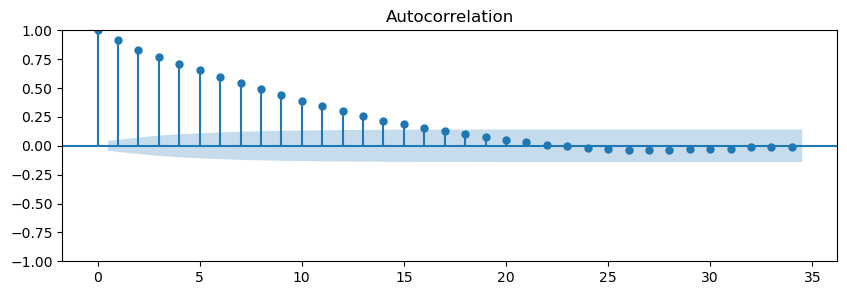

In [8]:
# ACF plot

fig, ax = plt.subplots(figsize=(10,3))
acf = plot_acf(df["Fuel Oil Cons. [kg/hour]"],ax=ax)

C:\Users\rdivy\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


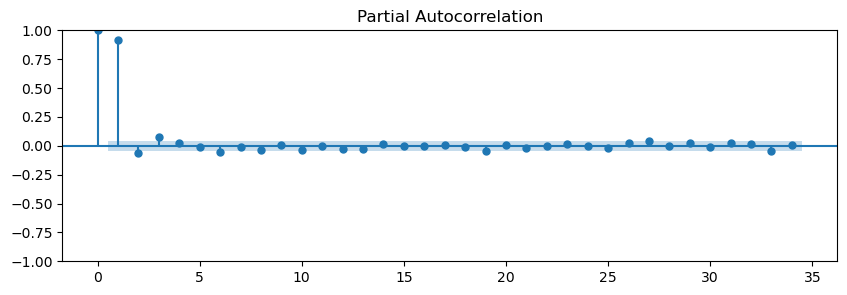

In [9]:
# PACF plot

fig, ax = plt.subplots(figsize=(10,3))
pacf = plot_pacf(df["Fuel Oil Cons. [kg/hour]"],ax=ax)

In [10]:
# defining p, d and q values based on the plots

q, p, d = 16, 1, 0

#### ARIMAX Model 

In [11]:
# Defining the dates column as the index of the dataframe

df["dates"] = pd.to_datetime(df["dates"])
df= df.set_index("dates")

In [12]:
# Splitting the dataset into train and test sets

train = df.loc[df.index <= "2023-08-01"]
test = df.loc[df.index > "2023-08-01"]

In [13]:
# Defining the exogeneous and endogeneous features

exo = ["Shaft Speed [RPM]","Torque [nM]"]
endo = ["Fuel Oil Cons. [kg/hour]"]

In [14]:
# Model fitting

import statsmodels.api as sm

model = sm.tsa.ARIMA(train[endo], order=(q, p, d), exog=train[exo])
result = model.fit()

C:\Users\rdivy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rdivy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rdivy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [15]:
# Defining start and end timeframe for forecasting

start_date = test.index[0].date()
end_date = test.index[-1].date()

#### Prediction

In [16]:
# Prediction

forecast = result.get_forecast(steps=len(test), exog=test[exo])
forecast_index = pd.date_range(start=test.index[0], periods=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

#### Evaluating the model

In [17]:
# Creating a dataframe to analyse the variation of prediction with the actual values

data = {'forecast_mean': forecast_mean, 'dates': forecast_index}
forecasts = pd.DataFrame(data)
forecasts.set_index("dates")
actualvspred = pd.merge(forecasts, test,on="dates")
actualvspred["residuals"] = abs(actualvspred["Fuel Oil Cons. [kg/hour]"] - actualvspred["forecast_mean"])
actualvspred = actualvspred[["Fuel Oil Cons. [kg/hour]","forecast_mean","residuals"]]

In [18]:
actualvspred # Dataframe showing the variation of the predicted values with actual values

,Fuel Oil Cons. [kg/hour],forecast_mean,residuals
0,1974.015972,1917.075436,56.940536
1,1714.130847,1674.200975,39.929873
2,1639.208333,1593.869123,45.339211
3,1641.690972,1610.654795,31.036177
4,1657.240384,1640.080181,17.160202
...,...,...,...
179,687.829167,685.184063,2.645104
180,849.513333,858.981584,9.468251
181,1142.059091,1133.355357,8.703734
182,1191.475397,1181.543799,9.931597


Text(0, 0.5, 'Density')

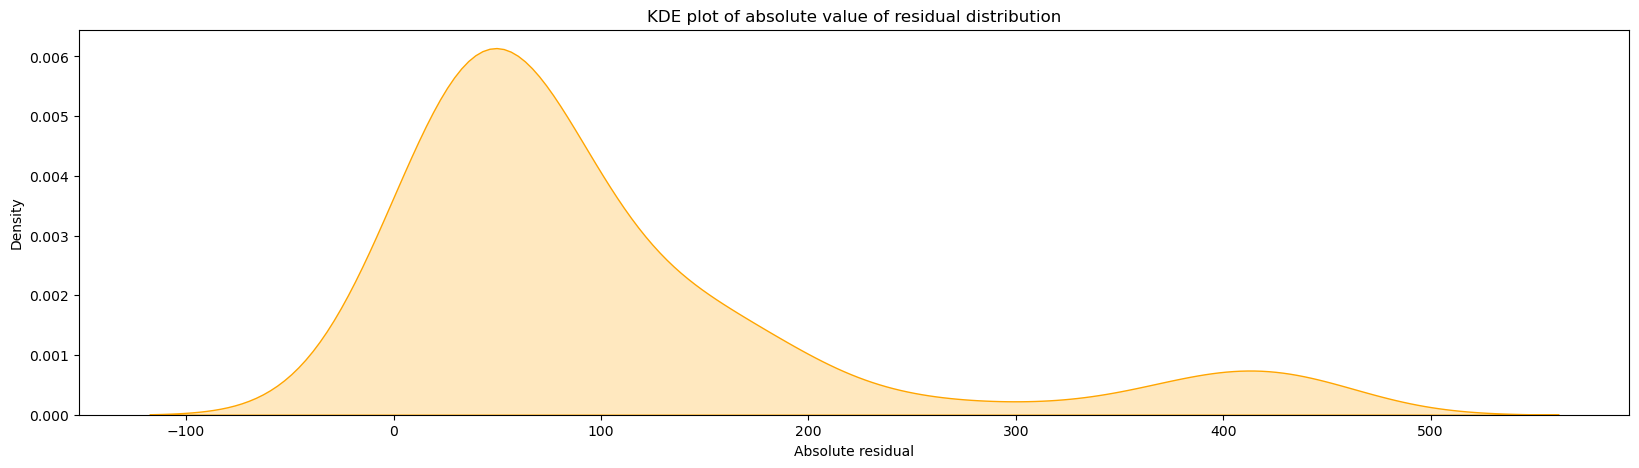

In [19]:
# Residuals plot

plt.figure(figsize=(20,5))
sb.kdeplot(data=actualvspred, x= "residuals", fill="True",color="orange")
plt.title("KDE plot of absolute value of residual distribution")
plt.xlabel("Absolute residual")
plt.ylabel("Density")

Text(0.5, 1.0, 'Actual values vs predicted values')

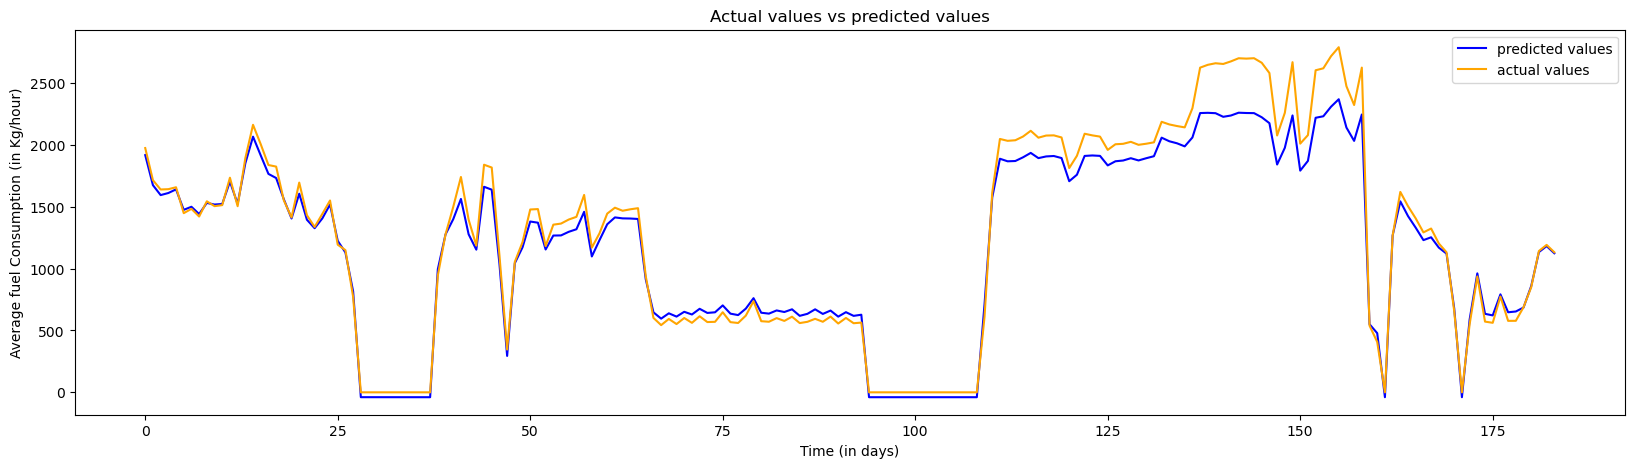

In [20]:
# Actual values vs predicted values plot

plt.figure(figsize=(20,5))

actualvspred["forecast_mean"].plot(color="blue",label = "predicted values")
actualvspred["Fuel Oil Cons. [kg/hour]"].plot(color="orange", label ="actual values")

plt.legend()
plt.xlabel("Time (in days)")
plt.ylabel("Average fuel Consumption (in Kg/hour)")
plt.title("Actual values vs predicted values")

In [21]:
# Evaluating the model with MAE and RMSE values

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actualvspred["Fuel Oil Cons. [kg/hour]"], actualvspred["forecast_mean"])
mse = mean_squared_error(actualvspred["Fuel Oil Cons. [kg/hour]"], actualvspred["forecast_mean"])
rmse = np.sqrt(mse)

print("MAE = " + str(mae))
print("RMSE = " + str(rmse))

MAE = 104.52234235851888
RMSE = 152.68982867609805
